# 基于BERT的自然语言处理

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## BERT模型介绍

在 BERT（Bidirectional Encoder Representations from Transformers）模型中，输入的维度通常是：

input_ids: 这个是将文本转换成的词汇表索引（token ids）。它的形状是 [batch_size, seq_len]，其中 batch_size 是每个批次的样本数，seq_len 是输入文本的最大长度（即模型的输入长度，通常由 max_length 参数控制）。

segment_info: 这个是一个用于表示句子 A 和句子 B 的信息（在BERT中通常用于句子对任务，如问答和自然语言推理）。它的形状也是 [batch_size, seq_len]，其中每个位置上的值通常是 0 或 1，分别代表句子 A 和句子 B。

### BERT架构

BERT架构： 一种基于多层Transformer编码器的预训练语言模型，通过结合Tokenization、多种Embeddings和特定任务的输出层，能够捕捉文本的双向上下文信息，并在各种自然语言处理任务中表现出色。
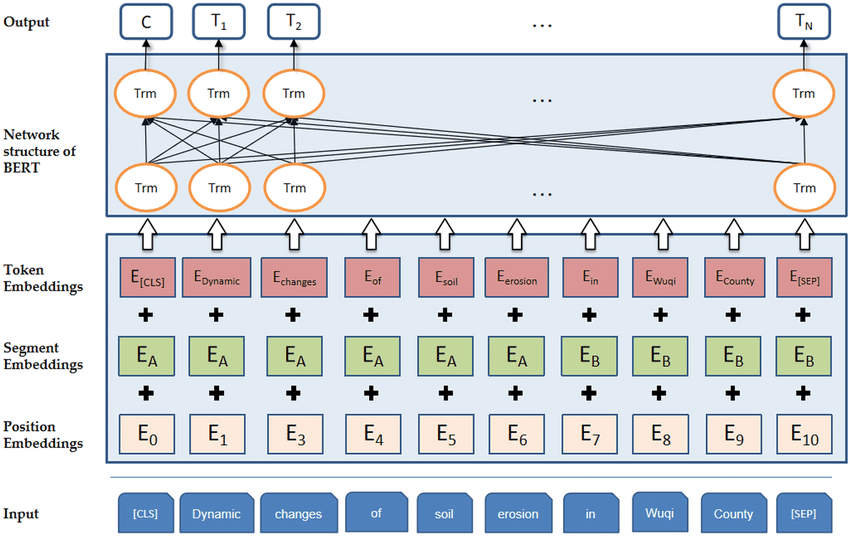

- 输入层 (Input)  
    BERT的输入是一个原始的文本序列，它可以是单个句子，也可以是两个句子（例如，问答任务中的问题和答案）。在输入到模型之前，这些文本需要经过特定的预处理步骤。


- Tokenization 和 Embeddings  
    Tokenization: 输入文本首先通过分词器（Tokenizer）被分割成Token。这一步通常包括将文本转换为小写、去除标点符号、分词等。BERT使用WordPiece分词方法，将单词进一步拆分成子词（subwords），以优化词汇表的大小和模型的泛化能力。

    Token Embeddings: 分词后的Token被映射到一个高维空间，形成Token Embeddings。这是通过查找一个预训练的嵌入矩阵来实现的，该矩阵为每个Token提供一个固定大小的向量表示。

    Segment Embeddings: 由于BERT能够处理两个句子作为输入（例如，在句子对分类任务中），因此需要一种方法来区分两个句子。Segment Embeddings用于此目的，为每个Token添加一个额外的嵌入，以指示它属于哪个句子（通常是“A”或“B”）。

    Position Embeddings: 由于[Transformer]模型本身不具有处理序列中Token位置信息的能力，因此需要位置嵌入来提供这一信息。每个位置都有一个独特的嵌入向量，这些向量在训练过程中学习得到。

    Token Embeddings、Segment Embeddings和Position Embeddings三者相加，得到每个Token的最终输入嵌入。

- BERT的网络结构 (Network Structure of BERT)  
    BERT的核心是由多个[Transformer]编码器层堆叠而成的。每个编码器层都包含自注意力机制和前馈神经网络，允许模型捕捉输入序列中的复杂依赖关系。

    自注意力机制: 允许模型在处理序列时关注不同位置的Token，并计算Token之间的注意力权重，从而捕捉输入序列中的依赖关系。

    前馈神经网络: 对自注意力机制的输出进行进一步转换，以提取更高级别的特征。

    残差连接和层归一化: 用于提高模型的训练稳定性和效果，有助于缓解梯度消失和梯度爆炸问题。

- 输出层 (Output)  
    BERT的输出取决于特定的任务。在预训练阶段，BERT采用了两种任务：Masked Language Model（MLM）和Next Sentence Prediction（NSP）。

    MLM: 在这种任务中，BERT预测输入序列中被随机遮盖的Token。模型的输出是每个被遮盖Token的概率分布，通过Softmax层得到。

    NSP: 这种任务要求BERT预测两个句子是否是连续的。模型的输出是一个二分类问题的概率分布。

### 词嵌入

#### Token Embeddings

Token Embeddings：

在BERT中，输入文本首先被分割成Token序列（单词、子词等），每个Token都会被映射到一个高维向量空间，形成Token Embeddings。这些嵌入捕获了Token的语义信息，是模型理解文本的基础。

Token Embeddings是通过在大规模语料库上进行无监督预训练得到的，这使得BERT能够理解和处理各种复杂的语言现象和语义关系。
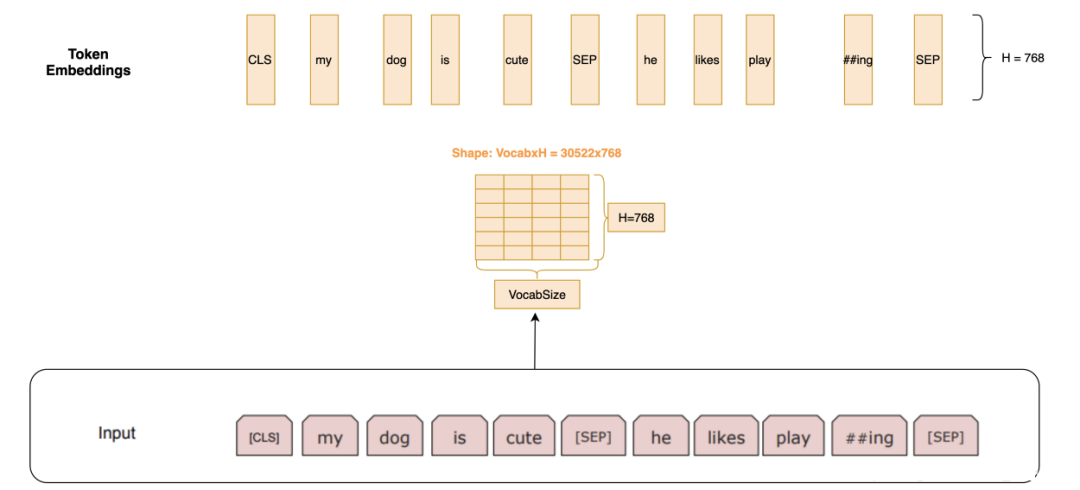

#### Segment Embeddings

Segment Embeddings：

为了处理像问答这样的任务，BERT引入了Segment Embeddings来区分两个不同但相关的句子（例如问题和答案）。这些嵌入帮助模型理解句子间的关系和边界。

在文本分类任务中，Segment Embeddings的作用可能不那么明显，因为输入通常是一个连续的文本段落。然而，它们仍然可以用于区分不同部分的文本，特别是在处理长文档或多个句子时。
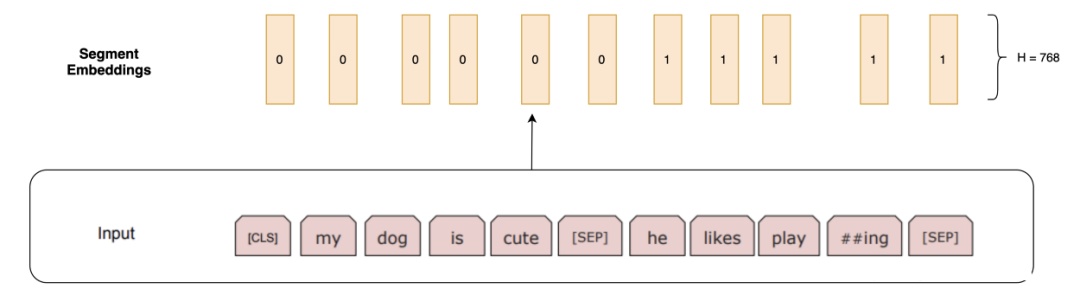

#### Position Embeddings

Position Embeddings：

由于Transformer结构本身不具备处理序列顺序的能力，BERT引入了Position Embeddings来捕获文本中Token的位置信息。

这些嵌入确保模型能够区分不同位置的相同Token，例如区分“hello，world”和“world，hello”中的“hello”和“world”。
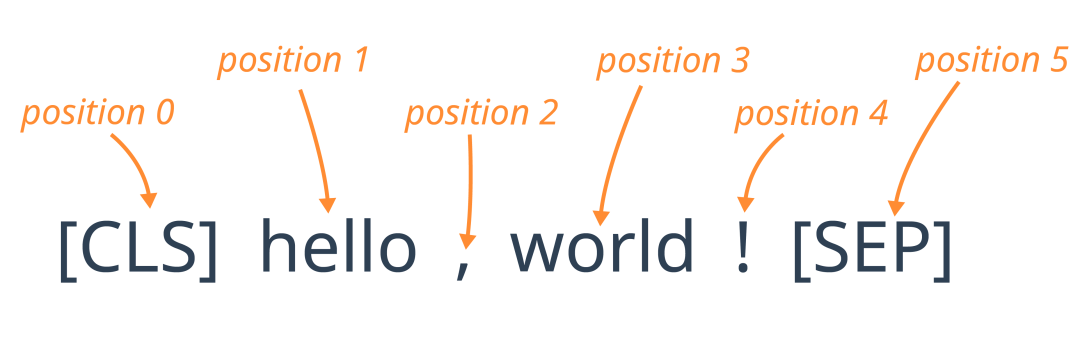

Position Embeddings与Token Embeddings和Segment Embeddings相加，形成最终的输入嵌入，这些嵌入随后被送入[Transformer]编码器进行处理。

### BERT原理

BERT的工作原理是通过在大规模未标注数据上执行预训练任务（如Masked Language Model来捕获文本中词汇的双向上下文关系，以及Next Sentence Prediction来理解句子间的逻辑关系），再将预训练的模型针对特定任务进行Fine tuning，从而在各种自然语言处理任务中实现高性能。
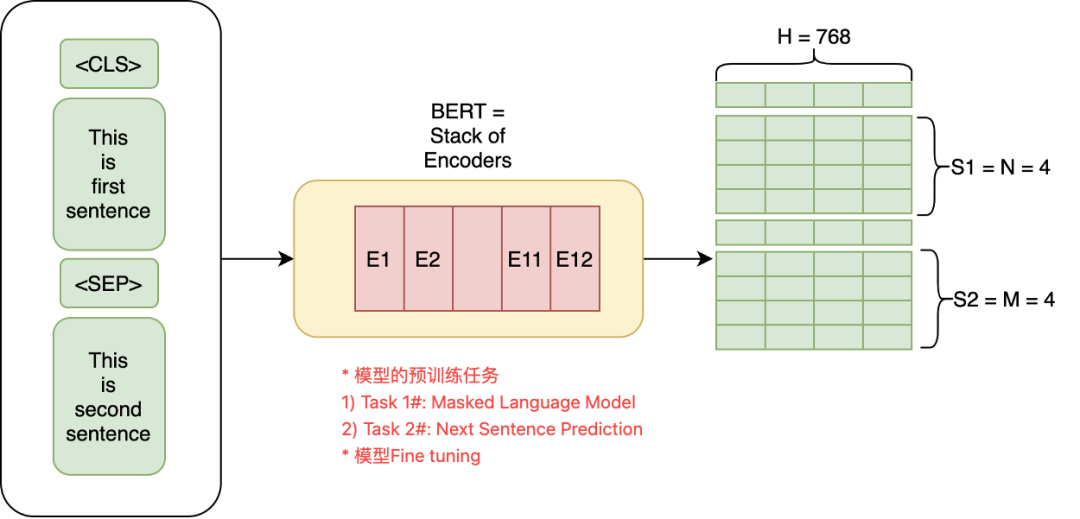
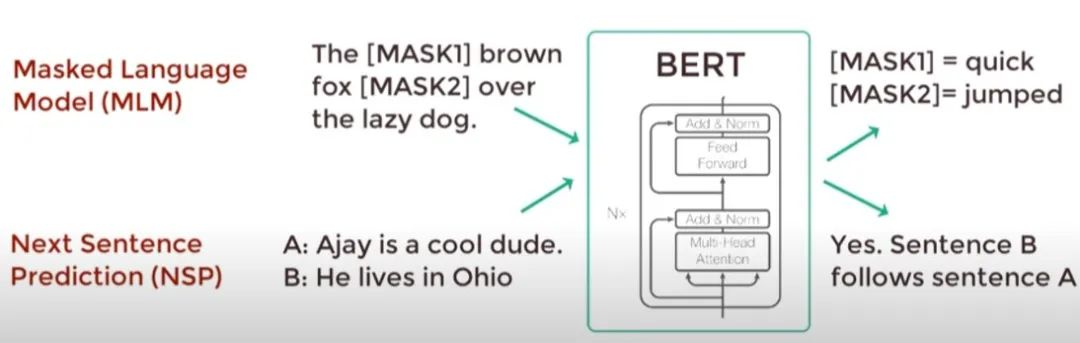

#### MLM

Masked Language Model (MLM)

任务描述：在输入的文本中，随机地遮盖或替换一部分词汇，并要求模型预测这些被遮盖或替换的词汇的原始内容。

目的：使模型能够利用双向的上下文信息来预测被遮盖的词汇，从而学习到更深层次的语义表示。

实现方式：在预训练阶段，BERT随机选择文本中15%的Token进行遮盖，其中80%的用[MASK]标记替换，10%的用随机词汇替换，剩下的10%保持不变。这种遮盖策略被称为动态遮盖，因为它在每次输入时都会随机改变遮盖的位置和词汇。

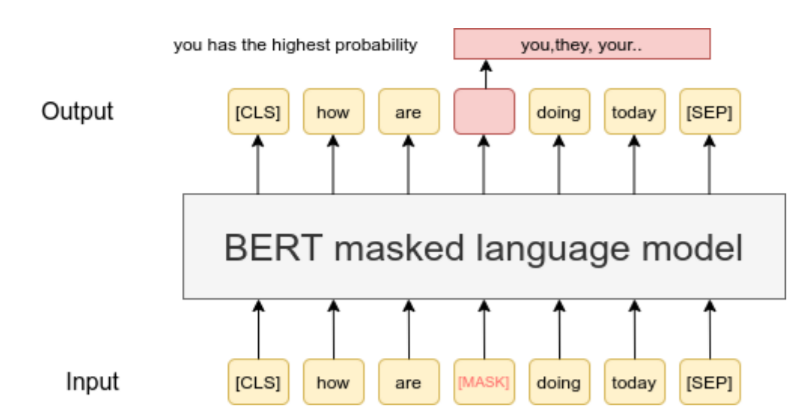

#### NSP

Next Sentence Prediction (NSP)

任务描述：给定一对句子，判断第二个句子是否是第一个句子的后续句子。

目的：使模型能够理解句子间的逻辑关系，如连贯性、因果关系等，从而提高其在处理长文档或复杂文本时的能力。

实现方式：在预训练阶段，BERT构造了一个二分类任务，其中50%的B是A的真正后续句子（标签为“IsNext”），另外50%的B是从语料库中随机选择的句子（标签为“NotNext”）。模型通过最后一层Transformer输出的[CLS]标记的嵌入来进行预测。

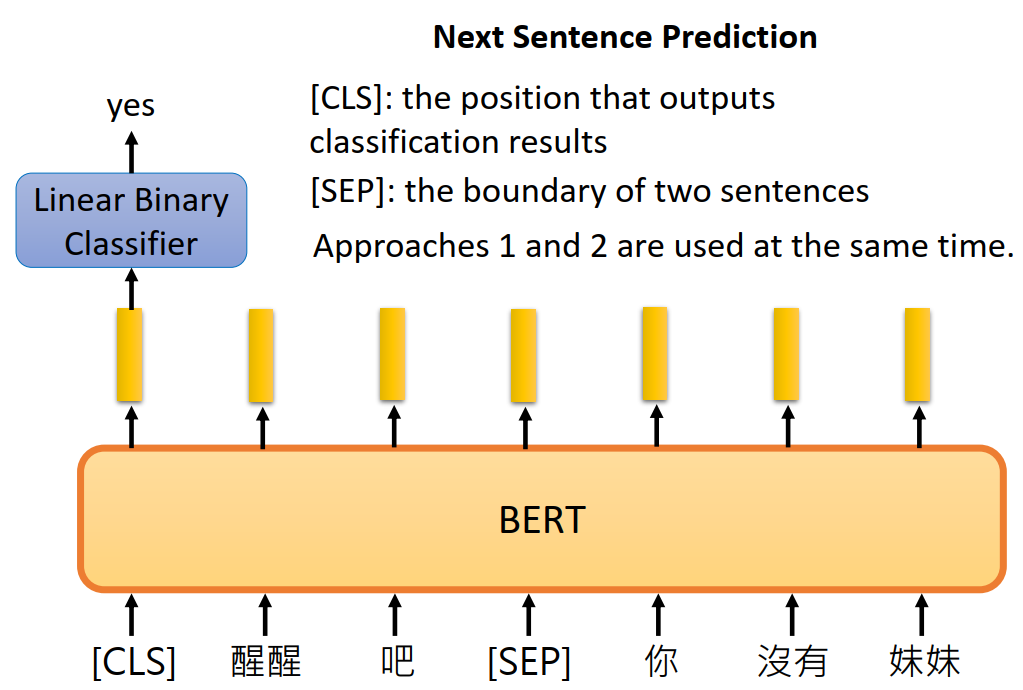

### 模型微调

BERT的fine-tuning过程是针对特定任务对预训练模型进行调整的过程，使其能够更好地适应和解决具体任务。根据任务类型的不同，对BERT模型的修改也会有所不同，但通常这些修改都相对简单，往往只需要在模型的输出部分加上一层或多层神经网络。

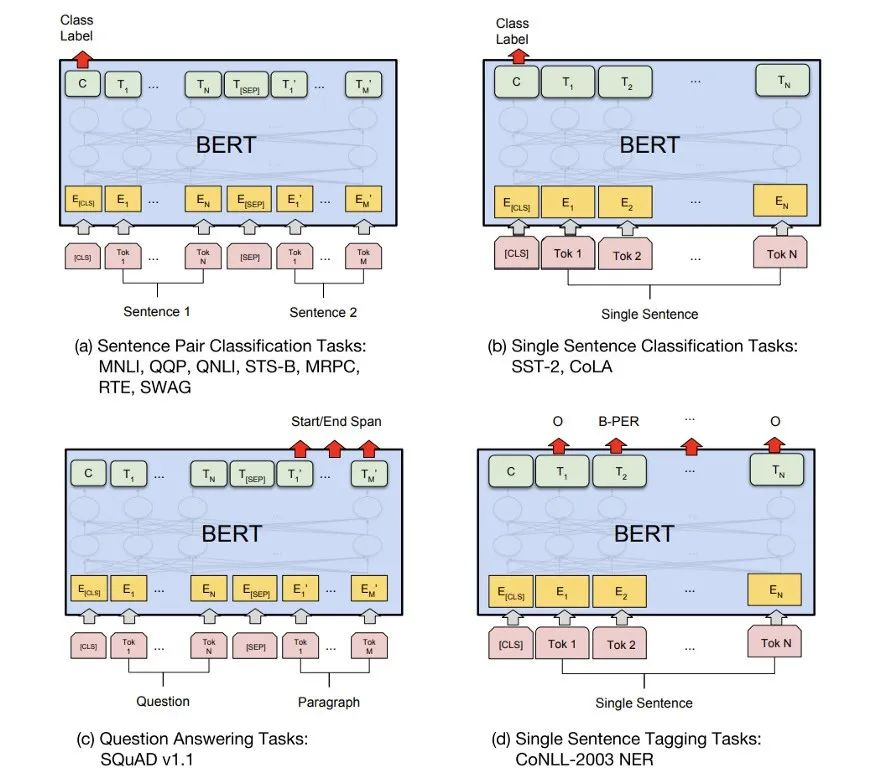

根据具体任务的不同，BERT的fine-tuning可以分为以下几种类型：

- 句子对分类任务（Sentence Pair Classification）：这种任务需要判断两个句子之间的关系，如文本蕴含、问答匹配等。在fine-tuning时，将两个句子一起输入模型，并取第一个token（[CLS]）的输出表示作为整个句子对的表示，然后将其输入到一个额外的softmax层进行分类。    
       
- 单句分类任务（Single Sentence Classification）：这种任务需要对单个句子进行分类，如情感分析、文本分类等。在fine-tuning时，将单个句子输入模型，并同样取第一个token（[CLS]）的输出表示进行分类。    

- 问答任务（Question Answering）：这种任务需要模型从给定的文本中找出问题的答案。在fine-tuning时，将问题和答案一起输入模型，并取答案部分在模型输出中的起始和结束位置作为答案的预测。

- 序列标注任务（Sequence Tagging，如命名实体识别NER）：这种任务需要对输入序列中的每个token进行分类，如识别文本中的实体、词性标注等。在fine-tuning时，取所有token在最后一层Transformer的输出，然后将其输入到一个额外的softmax层进行逐token的分类。

在进行fine-tuning时，对BERT模型的修改通常包括以下几个方面：

- 输入处理：根据任务类型的不同，对输入数据进行相应的处理，如将句子对拼接在一起、添加特殊标记等。

- 输出层：在BERT模型的输出部分添加一层或多层神经网络，用于将模型的输出转换为任务所需的格式。对于分类任务，通常添加一个softmax层进行概率分布的计算；对于序列标注任务，则逐token进行分类。

- 损失函数：根据任务类型选择合适的损失函数，如交叉熵损失函数用于分类任务、平方差损失函数用于回归任务等。

### BERT应用

#### 问答系统

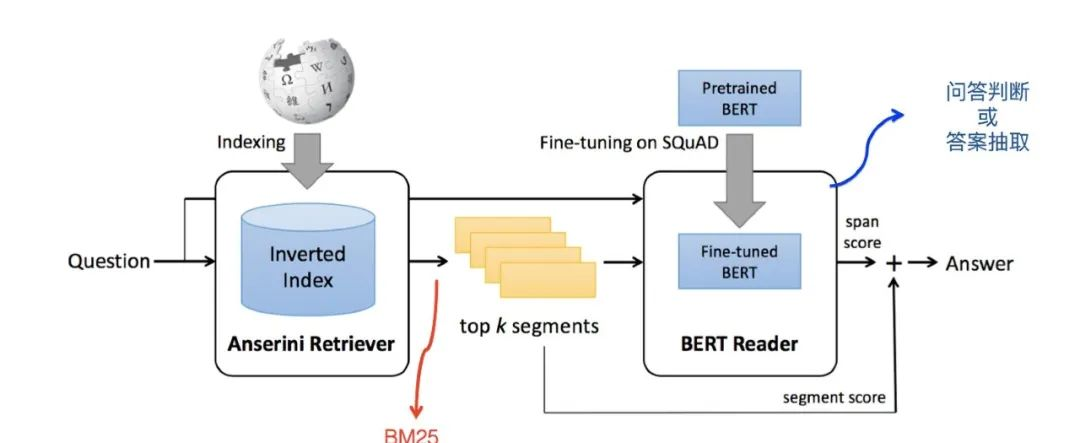

BERT在问答系统（QA）中的应用通常涉及两个阶段：检索阶段和问答判断阶段。

Question Answer(QA，问答系统)

一、检索阶段

文档处理：

切割：将长文档切割成较短的段落或句子（Passage），这些片段更容易处理和索引。

建立索引：利用倒排索引技术，为每个切割后的片段（Passage）建立索引，以便快速查询。

检索模型：

BM25模型：使用BM25或类似的检索函数（如BM25+RM3）计算问句与每个候选段落或句子的相关性得分。

候选选择：根据得分选择Top K个最相关的候选段落或句子。

二、问答判断阶段

模型准备：

Fine-tuning数据：选择适当的问答数据集（如SQuAD）或任务数据进行BERT模型的fine-tuning。

模型结构：在BERT模型的基础上，添加必要的输出层以适应问答任务，如分类层或起始/终止位置预测层。

问答处理：

输入构建：将用户问句和每个候选段落或句子组合成BERT模型的输入格式。

模型预测：使用fine-tuned BERT模型对每个输入进行预测，判断候选段落或句子是否包含正确答案，或者预测答案的精确位置。

答案选择：

评分机制：根据BERT模型的预测结果，为每个候选段落或句子分配得分。

最终答案：选择得分最高的候选段落或句子作为最终答案。


#### 聊天机器人

聊天机器人： BERT在聊天机器人中的应用主要涉及两个方面：用户意图分类和槽位填充（对于单轮对话），以及多轮对话中的上下文信息利用。
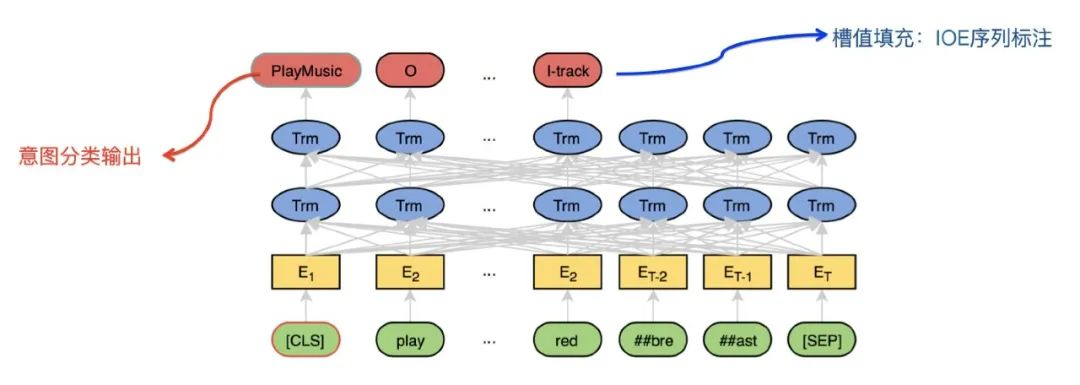
一、BERT在单轮对话中的应用

用户意图分类：

输入：将用户的话语作为BERT模型的输入。

模型结构：在BERT模型的基础上添加分类层，用于将用户意图分类到不同的服务类型中。

训练：使用带有意图标签的用户话语数据集进行fine-tuning，使模型能够准确识别用户意图。

任务描述：从用户的话语中解析出用户的意图，如订餐、点歌等。

BERT应用：

槽位填充：

输入：将用户的话语以及预定义的槽位作为BERT模型的输入。

模型结构：采用序列标注的方式，对每个输入token进行槽位标签的预测。

训练：使用带有槽位标签的用户话语数据集进行fine-tuning，使模型能够准确填充槽位信息。

任务描述：根据用户意图抽取关键元素，如订机票时的出发地、目的地等。

BERT应用：

二、BERT在多轮对话中的应用

上下文信息利用：

输入：将当前用户话语以及历史对话内容作为BERT模型的输入。

模型结构：可以采用多种策略来融入历史信息，如将历史对话与当前用户话语拼接、使用历史对话的嵌入表示等。

训练：使用多轮对话数据集进行fine-tuning，使模型能够正确理解和利用上下文信息来生成应答。

任务描述：在多轮对话中，利用历史交互信息来改进模型的应答。

BERT应用：

模型改进：

增加模型容量：通过增加BERT模型的层数或隐藏单元数来捕捉更多的上下文信息。

引入注意力机制：使用注意力机制来加权历史信息的重要性，使模型能够关注与当前应答最相关的部分。

记忆网络：结合记忆网络来存储和检索历史信息，以便在需要时提供给模型进行应答生成。

关键问题：如何有效融入更多的历史信息，并在上下文中正确地使用这些信息。

在 BERT（Bidirectional Encoder Representations from Transformers）模型中，输入的维度通常是：

input_ids: 这个是将文本转换成的词汇表索引（token ids）。它的形状是 [batch_size, seq_len]，其中 batch_size 是每个批次的样本数，seq_len 是输入文本的最大长度（即模型的输入长度，通常由 max_length 参数控制）。

segment_info: 这个是一个用于表示句子 A 和句子 B 的信息（在BERT中通常用于句子对任务，如问答和自然语言推理）。它的形状也是 [batch_size, seq_len]，其中每个位置上的值通常是 0 或 1，分别代表句子 A 和句子 B。

BERT 是一个双向 Transformer 模型，在预训练时使用了两种类型的任务：Masked Language Model（MLM）和 Next Sentence Prediction（NSP）。

BERT 预训练任务的核心：

NextSentencePrediction（NSP）：判断两个句子是否有上下文关系，用于训练模型理解句子间的逻辑关系。  
MaskedLanguageModel（MLM）：根据部分掩盖的句子预测掩盖的词汇，用于训练模型理解词汇的上下文信息。  

这两个任务结合起来帮助 BERT 在大规模语料库上学习语言的上下文依赖性，并且在实际应用中可以通过微调（fine-tuning）来处理各种 NLP 任务。

## 分类

### 数据准备

In [2]:
# 读取数据
def loader(folder_paths=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    folder_paths : {list}
        输入数据文件地址，支持多个文件

    返回值
    -------
    contents : {list}
        数据列表
    """
    # 读取原始数据
    if folder_paths == None:
        raise ValueError("folder is not exist!")

    contents = []
    # 遍历所有文件夹中的所有文件
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            # 检查文件是否为.txt文件
            if filename.endswith('.txt'):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    # 读取文件内容并加入到列表中
                    contents.append(file.read())
    return contents

In [3]:
# 负面标签为0，正面标签为1
folder_paths = ['../../../../../data/03.nlp/aclImdb/train/neg/', '../../../../../data/03.nlp/aclImdb/train/pos/']
texts = loader(folder_paths)
labels = [0]*12500 + [1]*12500

In [4]:
# 定义并初始化分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
def generator(data_list, train_ratio, valid_ratio, tokenizer, batch_size, max_length: int = 128):
    """
    读取数据，并对数据进行划分，生成加载器

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入数据，包含数据和标签
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    tokenizer : {}
        分词器
    batch_size : {int} 
        输入数据的批次大小，正整数
    max_length : {int} 
        最大文本截取长度，正整数

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器
    """
    # 获取数据
    texts = data_list[0]  # 特征
    labels = data_list[1]  # 目标
    
    # 划分数据
    train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=train_ratio, random_state=42)

    # 定义数据集的Dataset类
    class CustomDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
    
        def __len__(self):
            return len(self.labels)
    
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # 对文本进行token化，并转换为输入id和attention mask
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors="pt"
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }

    # 创建Dataset和DataLoader
    train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=max_length)
    val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, valid_loader

In [24]:
# 构造参数字典
params1 = {
    "data_list": [texts, labels],
    "train_ratio": 0.8,
    "valid_ratio": 0.1,
    "tokenizer": tokenizer,
    "batch_size": 64,
    "max_length": 200,
}

# 函数传参
train_loader, valid_loader = generator(**params1)

### 模型定义

In [25]:
import torch
import torch.nn as nn
import math

# 位置嵌入（PositionalEmbedding）：用于为输入的每个词汇位置添加位置信息（基于正弦和余弦函数）
class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

# 段落嵌入（SegmentEmbedding）：在BERT中用于表示输入的不同句子（如句子A和句子B）
class SegmentEmbedding(nn.Embedding):
    def __init__(self, embed_size=512):
        super().__init__(3, embed_size, padding_idx=0)

# 词汇嵌入（TokenEmbedding）：将输入的词汇ID映射到对应的词向量
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)


class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))


class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

# 残差连接和层归一化的组合
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)
    
# 将输入的ID序列转换为嵌入向量
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)


class BERT(nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = hidden * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=hidden)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # 注意力编码，torch.ByteTensor([batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x
    
# BERT完整模型，包含两大核心：NSP和MLM
class BERTLM(nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.hidden)
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

# Next Sentence Prediction (NSP) 任务的目标是让 BERT 学会判断给定的两个句子是否具有上下文关联，即第二个句子是否是第一个句子的自然后续。
class NextSentencePrediction(nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, 2)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x[:, 0]))

# Masked Language Model (MLM) 任务的目标是通过给定一个部分掩盖的句子，预测被掩盖（[MASK]）的位置的词汇。
# 这是 BERT 预训练过程中用于学习词汇表示和上下文信息的任务。
class MaskedLanguageModel(nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

In [26]:
# BERT分类任务
class BERTC(nn.Module):
    """
    BERTC : BERT分类模型.
    """
    def __init__(self, vocab_size, hidden_size, n_layers, attn_heads, dropout, num_classes=2):
        super(BERTC, self).__init__()
        self.bert = BERT(vocab_size=vocab_size, hidden=hidden_size, n_layers=n_layers, attn_heads=attn_heads, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)  # 分类头

    def forward(self, input_ids, segment_ids):
        # 获取 BERT 输出
        bert_output = self.bert(input_ids, segment_ids)
        # 取 BERT 输出的 [CLS] token 表示作为句子表示
        cls_output = bert_output[:, 0, :]  # 取第一个 token（[CLS] token）的输出
        output = self.fc(cls_output)  # 进行分类
        return output

### 模型训练

In [27]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch in train_loader:
            # 将数据移至 device
            batch_x = batch['input_ids'].to(device)
            batch_y = batch['label'].to(device)
            segment_ids = torch.zeros_like(batch_x).to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x, segment_ids)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            _, preds = torch.max(outputs, dim=1)
            train_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch in valid_loader:
                # 将数据移至 device
                batch_x = batch['input_ids'].to(device)
                batch_y = batch['label'].to(device)
                segment_ids = torch.zeros_like(batch_x).to(device)
                outputs = model(batch_x, segment_ids)
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
                val_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white")

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728', linewidth=2, marker='o', markersize=6)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4', linewidth=2, marker='s', markersize=6)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)

        # 添加图例
        plt.legend(fontsize=12, loc='upper right')

        # 启用横向网格线
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 可选：修改左侧和底部边框的样式
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)

        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)

        plt.gca().tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 展示图形
        plt.show()

    if plots:
        plot_loss(train_losses, val_losses)

    return model

In [28]:
# 构造参数字典
params2 = {
    "train_args": {
        "model_name": BERTC,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 5,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/BERTC",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'hidden_size': 768,
        'vocab_size': tokenizer.vocab_size, 
        'dropout': 0.1,
        'attn_heads': 12,
        'n_layers': 2,
        'num_classes': 2,
    },
}
model = train(**params2)

  0%|                                                                                           | 0/20 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 2.00 GiB total capacity; 8.74 GiB already allocated; 0 bytes free; 9.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF